# Imports

In [241]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score, precision_score, recall_score, f1_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.transforms import Bbox
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import rcParams
rcParams['text.usetex'] = True
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Preprocesing data

## Reading data

In [242]:
n_bound = 1
data_k = pd.read_excel('kernel_shuffled.xlsx',header=None)
data_b = pd.read_excel('bound_shuffled.xlsx', sheet_name=f'Sheet{n_bound}', header=None)

In [243]:
y_data_k = data_k.get(data_k.shape[1]-1)
X_data_k = data_k.drop(columns=data_k.shape[1]-1)
y_data_b = data_b.get(data_b.shape[1]-1) 
X_data_b = data_b.drop(columns=data_b.shape[1]-1)

## Spliting data

In [244]:
# Kernel train test
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_data_k, y_data_k, test_size=0.2)
# Bound train test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_data_b, y_data_b, test_size=0.2)

In [245]:
# Kernel + Bound train test
X_train_kb = pd.concat([X_train_k, X_train_b], axis=0)
y_train_kb = pd.concat([y_train_k, y_train_b], axis=0)
y_train_c = np.concatenate([np.zeros(y_train_k.shape), np.ones(y_train_b.shape)], axis=0).astype(int)
X_test_kb = pd.concat([X_test_k, X_test_b], axis=0)
y_test_kb = pd.concat([y_test_k, y_test_b], axis=0)
y_test_c = np.concatenate([np.zeros(y_test_k.shape), np.ones(y_test_b.shape)], axis=0).astype(int)

## Preparing data for classification

In [246]:
X_train = X_train_kb.assign(c=y_train_c, y=y_train_kb)
X_train = X_train.sample(frac=1).reset_index(drop=True)
y_train_class = X_train.get('c')
y_train_kb = X_train.get('y')
X_train_kb = X_train.drop(columns=['y','c'])

In [247]:
X_test = X_test_kb.assign(c=y_test_c, y=y_test_kb)
X_test = X_test.sample(frac=1,axis=0).reset_index(drop=True)
y_test_kb = X_test.get('y')
X_test = X_test.drop(columns='y')
y_test_class = X_test.get('c')
X_test_kb = X_test.drop(columns='c')

In [248]:
std_class = StandardScaler()
X_train_kb_std = std_class.fit_transform(X_train_kb, y_train_class)
X_test_kb_std = std_class.transform(X_test_kb)

(array([800.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

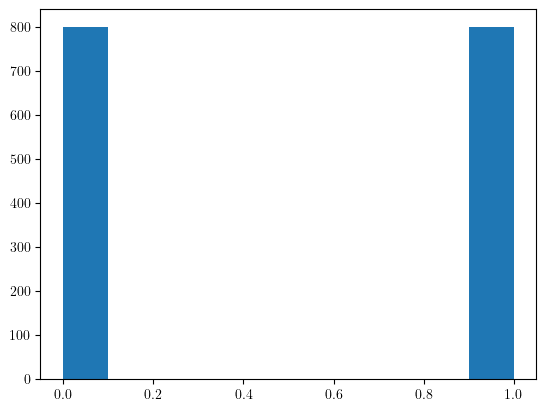

In [249]:
plt.hist(y_train_class)

## Preparing data for regression

In [250]:
std = StandardScaler()
# Kernel --> 
X_train_k_std = std.fit_transform(X_train_k, y_train_k)
# --> Kernel
X_test_k_k_std = std.transform(X_test_k)
# --> Bound
X_test_k_b_std = std.transform(X_test_b)

In [251]:
std2 = StandardScaler()
# Bound --> 
X_train_b_std = std2.fit_transform(X_train_b, y_train_b)
# --> Bound
X_test_b_b_std = std2.transform(X_test_b)
# --> Kernel
X_test_b_k_std = std2.transform(X_test_k)

In [252]:
std3 = StandardScaler()
# Kernel + Bound -->
X_train_kb_std = std3.fit_transform(X_train_kb, y_train_kb)
# --> Kernel
X_test_kb_k_std = std3.transform(X_test_k)
# --> Bound
X_test_kb_b_std = std3.transform(X_test_b)

In [253]:
y_test_b

50     0.000454
108    0.000598
17     0.000573
567    0.000507
806    0.000575
         ...   
393    0.000622
41     0.000641
14     0.000574
273    0.000461
531    0.000506
Name: 6, Length: 200, dtype: float64

# ML Classification models

Logistic Regression Report
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       200
           1       0.89      0.95      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400

0.9170435132147523
0.915
0.9148957472904309
SVM Report
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       200
           1       0.90      0.94      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

0.9180120647793547
0.9175
0.917474726635032

 Decision Tree 
 	 mean precision 	 mean recall 	 	 mean fscore 

0.0 	 0.9209 	 	 0.908 	 	 0.9144 

1.0 	 0.9093 	 	 0.922 	 	 0.9156 

	 std precision 	 	 std recall 	 	 std fscore 

0.0 	 0.0037 	 	 0.006 	 	 0.00

<Figure size 640x480 with 0 Axes>

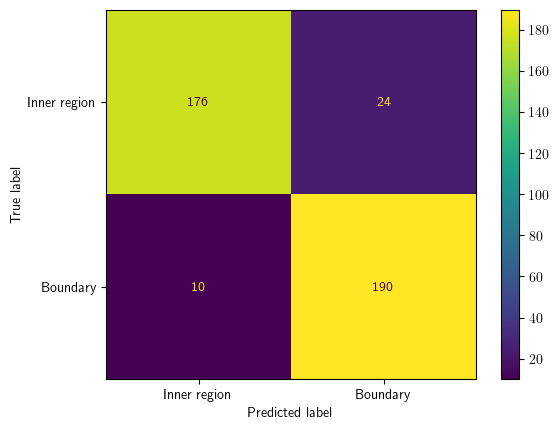

<Figure size 640x480 with 0 Axes>

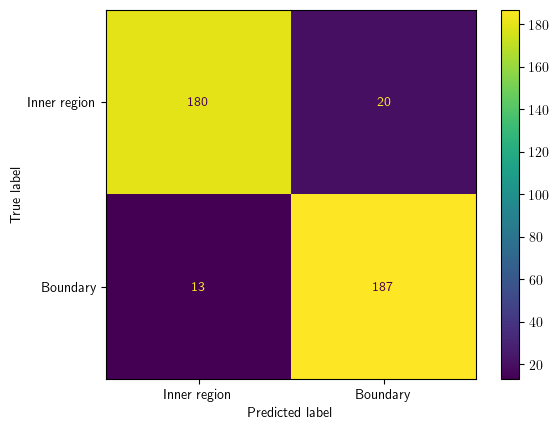

<Figure size 640x480 with 0 Axes>

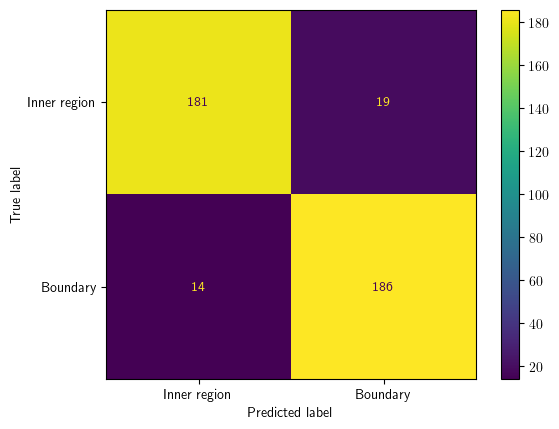

<Figure size 640x480 with 0 Axes>

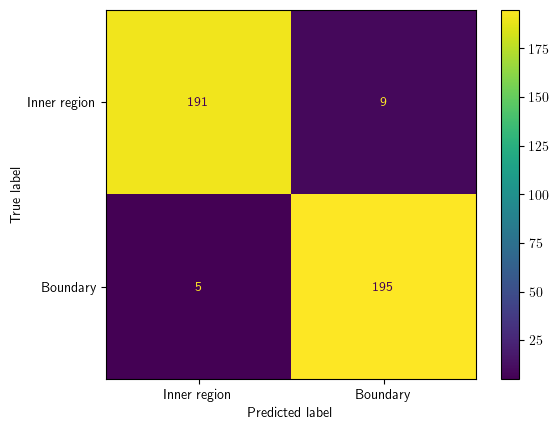

In [254]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

#LR
lr = LogisticRegression()
lr.fit(X_train_kb_std, y_train_class)
y_predict_lr = lr.predict(X_test_kb_std)
print('Logistic Regression Report\n', classification_report(y_test_class, y_predict_lr))
print(precision_score(y_test_class, y_predict_lr, average='weighted'))
print(recall_score(y_test_class, y_predict_lr, average='weighted'))
print(f1_score(y_test_class, y_predict_lr, average='weighted'))

#SVC
svc = SVC()
svc.fit(X_train_kb_std, y_train_class)
y_predict_svc = svc.predict(X_test_kb_std)
print('SVM Report\n', classification_report(y_test_class, y_predict_svc))
print(precision_score(y_test_class, y_predict_svc, average='weighted'))
print(recall_score(y_test_class, y_predict_svc, average='weighted'))
print(f1_score(y_test_class, y_predict_svc, average='weighted'))

#DT
precision_dt = []
recall_dt = []
fscore_dt = []
support_dt = []
precision_score_dt = []
recall_score_dt = []
f1_score_dt = []
for r in range(5):
    dt = DecisionTreeClassifier()
    dt.fit(X_train_kb_std, y_train_class)
    y_predict_dt = dt.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_dt.append(precision)
    recall_dt.append(recall)
    fscore_dt.append(fscore)
    support_dt.append(support)

    p_s = precision_score(y_test_class, y_predict_dt, average='weighted')
    r_s = recall_score(y_test_class, y_predict_dt, average='weighted')
    f_s = f1_score(y_test_class, y_predict_dt, average='weighted')

    precision_score_dt.append(p_s)
    recall_score_dt.append(r_s)
    f1_score_dt.append(f_s)

precision_dt = np.array(precision_dt)
mean_precision_dt = np.mean(precision_dt, axis=0)
std_precision_dt = np.std(precision_dt, axis=0)

recall_dt = np.array(recall_dt)
mean_recall_dt = np.mean(recall_dt, axis=0)
std_recall_dt = np.std(recall_dt, axis=0)

fscore_dt = np.array(fscore_dt)
mean_fscore_dt = np.mean(fscore_dt, axis=0)
std_fscore_dt = np.std(fscore_dt, axis=0)

support_dt = np.array(support_dt)
mean_support_dt = np.mean(support_dt, axis=0)
std_support_dt = np.std(support_dt, axis=0)

print('\n','Decision Tree', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_dt[0], 4), '\t \t', round(mean_recall_dt[0], 4), '\t \t', round(mean_fscore_dt[0], 4), '\n')
print('1.0', '\t', round(mean_precision_dt[1], 4), '\t \t', round(mean_recall_dt[1], 4), '\t \t', round(mean_fscore_dt[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_dt[0], 4), '\t \t', round(std_recall_dt[0], 4), '\t \t', round(std_fscore_dt[0], 4), '\n')
print('1.0','\t', round(std_precision_dt[1], 4), '\t \t', round(std_recall_dt[1], 4), '\t \t', round(std_fscore_dt[1], 4), '\n')

print(np.mean(precision_score_dt))
print(np.mean(recall_score_dt))
print(np.mean(f1_score_dt))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

#RF
precision_rf = []
recall_rf = []
fscore_rf = []
support_rf = []
precision_score_rf = []
recall_score_rf = []
f1_score_rf = []
for r in range(5):
    rf = RandomForestClassifier()
    rf.fit(X_train_kb_std, y_train_class)
    y_predict_rf = rf.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_rf.append(precision)
    recall_rf.append(recall)
    fscore_rf.append(fscore)
    support_rf.append(support)

    p_s = precision_score(y_test_class, y_predict_rf, average='weighted')
    r_s = recall_score(y_test_class, y_predict_rf, average='weighted')
    f_s = f1_score(y_test_class, y_predict_rf, average='weighted')

    precision_score_rf.append(p_s)
    recall_score_rf.append(r_s)
    f1_score_rf.append(f_s)

precision_rf = np.array(precision_rf)
mean_precision_rf = np.mean(precision_rf, axis=0)
std_precision_rf = np.std(precision_rf, axis=0)

recall_rf = np.array(recall_rf)
mean_recall_rf = np.mean(recall_rf, axis=0)
std_recall_rf= np.std(recall_rf, axis=0)

fscore_rf = np.array(fscore_rf)
mean_fscore_rf = np.mean(fscore_rf, axis=0)
std_fscore_rf = np.std(fscore_rf, axis=0)


support_rf = np.array(support_rf)
mean_support_rf = np.mean(support_rf, axis=0)
std_support_rf = np.std(support_rf, axis=0)

print('\n','Random Forest', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_rf[0], 4), '\t \t', round(mean_recall_rf[0], 4), '\t \t', round(mean_fscore_rf[0], 4), '\n')
print('1.0', '\t', round(mean_precision_rf[1], 4), '\t \t', round(mean_recall_rf[1], 4), '\t \t', round(mean_fscore_rf[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_rf[0], 4), '\t \t \t', round(std_recall_rf[0], 4), '\t \t \t', round(std_fscore_rf[0], 4), '\n')
print('1.0','\t', round(std_precision_rf[1], 4), '\t \t \t', round(std_recall_rf[1], 4), '\t \t \t', round(std_fscore_rf[1], 4), '\n')

print(np.mean(precision_score_rf))
print(np.mean(recall_score_rf))
print(np.mean(f1_score_rf))

fig1 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_lr,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_lr.eps')
plt.show()

fig2 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_svc,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_svc.eps')
plt.show()

fig3 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_dt,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_dt.eps')
plt.show()

fig4 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_rf,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_rf.eps')
plt.show()

# Regression problem

## Testing the Kernel

### Kernel --> Kernel

In [255]:
#Kernel data
#Train data', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_k_std, y_train_k)
y_predict_mlp_k = mlp.predict(X_test_k_k_std)

#param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#          'activation': ['relu','tanh','logistic'],
#          'alpha': [0.0001, 0.05, 0.1],
#          'learning_rate': ['constant','adaptive'],
#          'solver': ['adam','sgd']}

#gsc = GridSearchCV(mlp,param_grid,cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#grid_result = gsc.fit(X_train_k_std, y_train_k)

#print(grid_result.best_params_)

#y_predict_mlp_k = gsc.predict(X_test_k_k_std)


lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
    r2 = r2_score(y_test_k, y_predict_dt_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_dt_k)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
    r2 = r2_score(y_test_k, y_predict_rf_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_rf_k)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_k))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_mlp_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_k))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_k, y_predict_lr_k)
mae_mlp = metrics.mean_absolute_error(y_test_k, y_predict_mlp_k)
mae_svr = metrics.mean_absolute_error(y_test_k, y_predict_svr_k)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_k, y_predict_lr_k)
r2_mlp = r2_score(y_test_k, y_predict_mlp_k)
r2_svr = r2_score(y_test_k, y_predict_svr_k)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_k, y_predict_lr_k)
mape_mlp = mean_absolute_percentage_error(y_test_k, y_predict_mlp_k)
mape_svr = mean_absolute_percentage_error(y_test_k, y_predict_svr_k)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )


Root Mean Squared Error:
 LR: 	 0.0001417539384484956 
 MLP: 	 0.031952415646682136 
 SVR: 	 0.00022346849513085344 
 DT: 	 0.000208324279754579 
 RF: 	 0.00012546138014226348 

Mean Absolute Error:
 LR: 	 0.000108385052380778 
 MLP: 	 0.0246482395213561 
 SVR: 	 0.00018507752538820602 
 DT: 	 0.00015789242039937037 
 RF: 	 0.00010317211801408004 

R2 Score:
 LR: 	 0.5954828303691331 
 MLP: 	 -20551.946217001845 
 SVR: 	 -0.005308375014936084 
 DT: 	 0.12615271980517018 
 RF: 	 0.6830400913500375 

MAPE Score:
 LR: 	 0.0684359618599555 
 MLP: 	 15.184279506172283 
 SVR: 	 0.11510067970373726 
 DT: 	 0.09750823892292822 
 RF: 	 0.06502854452238511 



#### ML vs True comparison

In [257]:
test_df_k = X_test_k.copy()
test_df_k.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
test_df_k.insert(len(test_df_k.columns), 'true', y_test_k)
test_df_k.insert(len(test_df_k.columns), 'lr_predict', y_predict_lr_k)
test_df_k.insert(len(test_df_k.columns), 'mlp_predict', y_predict_mlp_k)
test_df_k.insert(len(test_df_k.columns), 'svr_predict', y_predict_svr_k)
test_df_k.insert(len(test_df_k.columns), 'dt_predict', y_predict_dt_k)
test_df_k.insert(len(test_df_k.columns), 'rf_predict', y_predict_rf_k)
test_df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
651,198206.859594,443.448085,2.872686,1038.996590,165666.546137,2604.922254,0.001783,0.001765,-0.014004,0.001644,0.001569,0.001624
334,197345.039968,426.700225,3.243840,215.851877,16001.405342,1187.314084,0.001842,0.001630,-0.009256,0.001644,0.001841,0.001703
939,196288.127613,423.857315,2.728308,840.930024,110014.389297,2343.514441,0.001787,0.001791,-0.028062,0.001644,0.001392,0.001610
925,198768.444910,442.816889,3.519963,35.179567,4544.404336,479.328168,0.001315,0.001576,-0.021711,0.001644,0.001722,0.001598
753,204798.720373,461.293071,2.944252,564.535253,68544.733821,1920.141519,0.001873,0.001802,0.027534,0.001644,0.001869,0.001734
...,...,...,...,...,...,...,...,...,...,...,...,...
770,198419.499261,445.343097,3.485979,146.488533,20367.603054,978.114099,0.001505,0.001603,-0.007818,0.001644,0.001835,0.001661
896,204095.795287,428.263627,3.097608,403.680254,59610.710291,1623.702496,0.001538,0.001543,-0.030297,0.001644,0.001494,0.001519
832,200691.341023,496.804148,3.797073,304.502148,33779.581204,1410.207061,0.001971,0.001847,-0.028576,0.001644,0.001412,0.001747
941,202348.064820,439.365605,3.339187,109.675238,10731.019698,846.334407,0.001676,0.001568,-0.028042,0.001644,0.001756,0.001694


In [258]:
train_df_k = X_train_k.copy()
train_df_k.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
train_df_k.insert(len(train_df_k.columns), 'true', y_train_k)
train_df_k.insert(len(train_df_k.columns), 'lr_predict', lr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'mlp_predict', mlp.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'svr_predict', svr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'dt_predict', dt.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'rf_predict', rf.predict(X_train_k_std))
train_df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
509,196948.382979,420.856519,3.383558,113.365145,6974.405419,860.453646,0.001824,0.001552,0.007419,0.001644,0.001824,0.001792
512,196177.352456,414.668086,2.741187,513.717684,79037.842545,1831.681516,0.001609,0.001607,-0.008809,0.001644,0.001609,0.001587
87,197109.890928,418.267269,3.768111,956.544740,128682.370950,2499.426377,0.001583,0.001650,0.020534,0.001644,0.001583,0.001610
225,203282.617096,402.418912,2.984810,840.286142,152893.010530,2342.617079,0.001373,0.001395,0.003829,0.001644,0.001373,0.001406
173,198606.809966,441.278261,3.420435,55.656505,5465.628552,602.900537,0.001635,0.001591,-0.005420,0.001644,0.001635,0.001679
...,...,...,...,...,...,...,...,...,...,...,...,...
244,203184.139063,458.576496,3.495006,50.603185,4332.156658,574.879249,0.001750,0.001618,-0.043520,0.001644,0.001750,0.001686
473,204041.556723,448.880861,4.013006,1120.916893,212282.771544,2705.667418,0.001408,0.001457,-0.014857,0.001644,0.001408,0.001445
746,195841.043512,462.997000,2.682997,1124.045137,320875.977560,2709.440263,0.001568,0.001271,0.038930,0.001644,0.001568,0.001592
839,202862.328426,486.240751,3.252518,46.142606,3524.958254,548.957551,0.001986,0.001778,-0.053453,0.001644,0.001986,0.001968


In [259]:
df_k = pd.concat([train_df_k, test_df_k], ignore_index=True, axis=0)
df_k.to_csv('./data/kernel-with-predictions.csv', index=False)
df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
0,196948.382979,420.856519,3.383558,113.365145,6974.405419,860.453646,0.001824,0.001552,0.007419,0.001644,0.001824,0.001792
1,196177.352456,414.668086,2.741187,513.717684,79037.842545,1831.681516,0.001609,0.001607,-0.008809,0.001644,0.001609,0.001587
2,197109.890928,418.267269,3.768111,956.544740,128682.370950,2499.426377,0.001583,0.001650,0.020534,0.001644,0.001583,0.001610
3,203282.617096,402.418912,2.984810,840.286142,152893.010530,2342.617079,0.001373,0.001395,0.003829,0.001644,0.001373,0.001406
4,198606.809966,441.278261,3.420435,55.656505,5465.628552,602.900537,0.001635,0.001591,-0.005420,0.001644,0.001635,0.001679
...,...,...,...,...,...,...,...,...,...,...,...,...
995,198419.499261,445.343097,3.485979,146.488533,20367.603054,978.114099,0.001505,0.001603,-0.007818,0.001644,0.001835,0.001661
996,204095.795287,428.263627,3.097608,403.680254,59610.710291,1623.702496,0.001538,0.001543,-0.030297,0.001644,0.001494,0.001519
997,200691.341023,496.804148,3.797073,304.502148,33779.581204,1410.207061,0.001971,0.001847,-0.028576,0.001644,0.001412,0.001747
998,202348.064820,439.365605,3.339187,109.675238,10731.019698,846.334407,0.001676,0.001568,-0.028042,0.001644,0.001756,0.001694


### Heat map

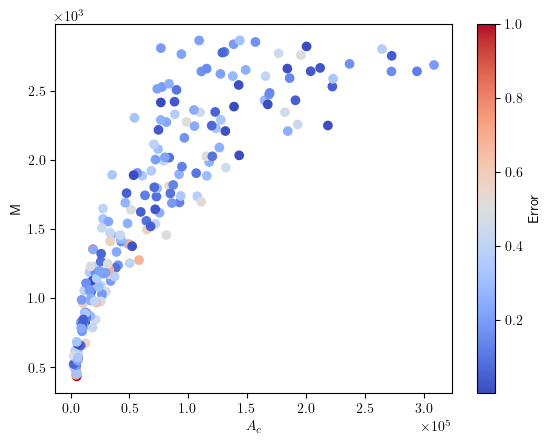

In [260]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = np.abs(y_test_k - y_predict_rf_k)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

### Heat map

<Figure size 640x480 with 0 Axes>

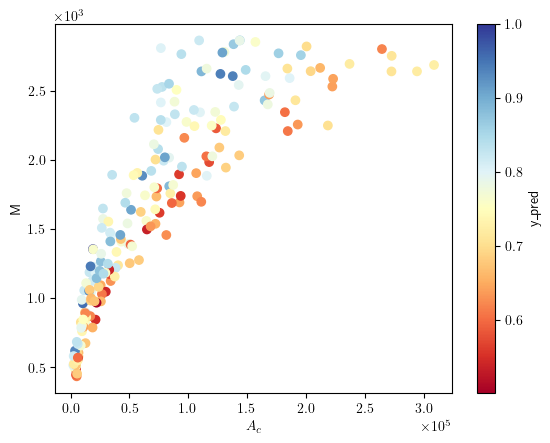

In [261]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = y_test_k
col1 = col1/col1.max()
plt.show()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-real.eps',format='eps',dpi=300)
plt.show()

In [262]:
print(X_train_k_std.shape)
print(y_train_k.shape)

(800, 6)
(800,)


In [263]:
# # TENSORFLOW
# def build_model():
#     model = keras.Sequential([
#         layers.Conv1D(16, 1, input_shape=[X_train_b_std.shape[1],1]),
#         layers.Conv1D(8, 1),
#         layers.Conv1D(4, 1),
#         #layers.Dense(32, activation='relu', input_shape=[X_train_b_std.shape[1]]),
#         #layers.Dropout(0.1),
#         #layers.Dense(16, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Flatten(),
#         layers.Dense(4, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Dense(1, activation='linear')
#     ])

#     optimizer = tf.keras.optimizers.Adam(0.001)

#     model.compile(loss='mse',
#         optimizer=optimizer,
#         metrics=['mae', 'mse'])
#     return model


# model = build_model()
# model.summary()

# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [Strain]')
#     plt.plot(hist['epoch'], hist['mae'])
#     plt.ylabel('Mean Square Error [$Strain^2$]')
#     plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
#     plt.legend()
#     plt.show()


# #early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


# history = model.fit(X_train_b_std, y_train_b, epochs=1000, validation_split = 0.2, verbose=1)

# plot_history(history)

# test_predictions = model.predict(X_test_b_b_std).flatten()

# print(test_predictions.shape)
# print(y_test_b.shape)

# plt.scatter(y_test_b, test_predictions)
# plt.xlabel('True Values [Strain]')
# plt.ylabel('Predictions [Strain]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
# plt.show()

# error = test_predictions - y_test_b
# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Strain]")
# _ = plt.ylabel("Count")
# plt.show()

# rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, test_predictions))
# mae_mlp = metrics.mean_absolute_error(y_test_b, test_predictions)
# r2_mlp = r2_score(y_test_b, test_predictions)
# mape_mlp = mean_absolute_percentage_error(y_test_b, test_predictions)

# print(f'RSME: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

### TENSORFLOW
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[X_train_kb_std.shape[1]]),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    return model


model = build_model()
model.summary()

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Strain]')
    plt.plot(hist['epoch'], hist['mae'])
    plt.ylabel('Mean Square Error [$Strain^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.show()


#early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


history = model.fit(X_train_kb_std, y_train_kb, epochs=1000, validation_split = 0.2, verbose=1)

plot_history(history)

test_predictions = model.predict(X_test_kb_std).flatten()

plt.scatter(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
plt.xlabel('True Values [Strain]')
plt.ylabel('Predictions [Strain]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = test_predictions[y_test_class==1] - y_test_kb[y_test_class==1]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Strain]")
_ = plt.ylabel("Count")
plt.show()

rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1]))
mae_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
r2_mlp = r2_score(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
mape_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])

print(f'RMSE: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

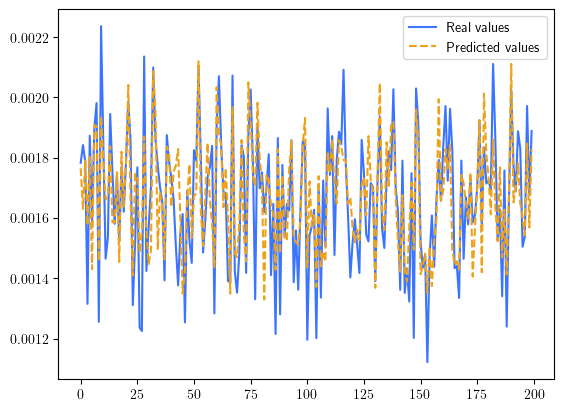

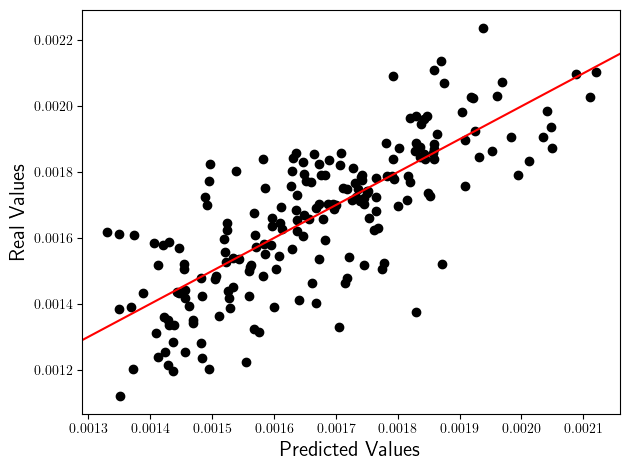

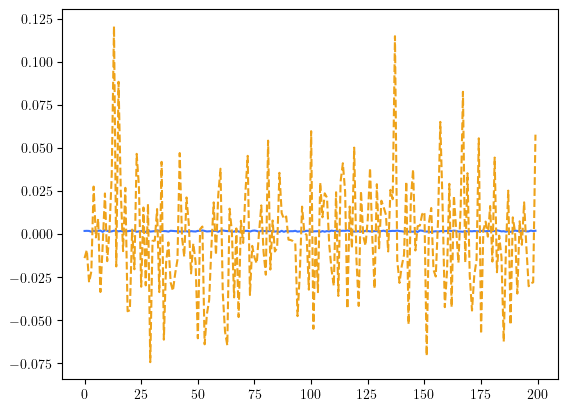

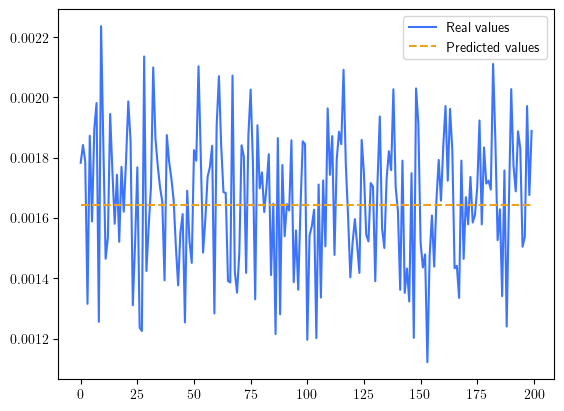

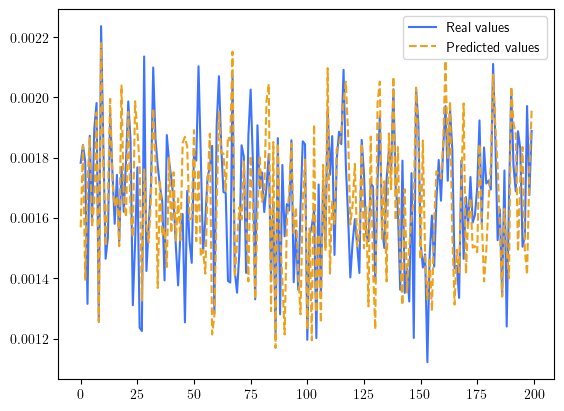

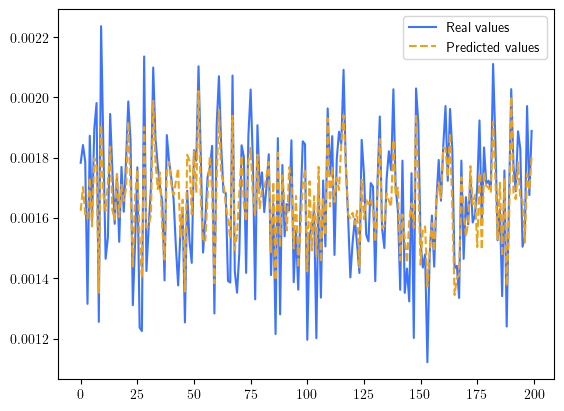

In [264]:
pretty_blue = '#3C74FF'
nice_orange = '#EEA219'

x=np.arange(0,len(y_test_k),1)

fig1_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig_true_predict_k, ax = plt.subplots()
plt.plot(y_predict_lr_k, y_test_k, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/kernel-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_mlp_k, '--', color=nice_orange, label='Predicted values')

fig3_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig5_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

#fig6_k = plt.figure()
#plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
#plt.plot(x,test_predictions, '--', color=nice_orange, label='Predicted values')
#plt.legend()
#plt.show()


### Kernel --> Bound

In [265]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [266]:
lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_k)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_k)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_k))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.0008518571873578004 
 0.0011053480535419733 
 9.232121232047032e-07 
 9.251644198133858e-07 



## Testing the Bound

### Bound --> Bound

In [267]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [268]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_b_std, y_train_b)
y_predict_mlp_b = mlp.predict(X_test_b_b_std)

lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_b))
    r2 = r2_score(y_test_b, y_predict_dt_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_dt_b)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_b))
    r2 = r2_score(y_test_b, y_predict_rf_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_rf_b)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_b))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_mlp_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_b))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_b, y_predict_lr_b)
mae_mlp = metrics.mean_absolute_error(y_test_b, y_predict_mlp_b)
mae_svr = metrics.mean_absolute_error(y_test_b, y_predict_svr_b)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_b, y_predict_lr_b)
r2_mlp = r2_score(y_test_b, y_predict_mlp_b)
r2_svr = r2_score(y_test_b, y_predict_svr_b)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_mlp = mean_absolute_percentage_error(y_test_b, y_predict_mlp_b)
mape_svr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

Root Mean Squared Error:
 LR: 	 5.573350588387823e-06 
 MLP: 	 0.030815461275358808 
 SVR: 	 6.212060112083825e-05 
 DT: 	 1.0453494680533146e-05 
 RF: 	 7.302331790979351e-06 

Mean Absolute Error:
 LR: 	 4.147405264384037e-06 
 MLP: 	 0.024431591577653594 
 SVR: 	 5.05487193717798e-05 
 DT: 	 8.021292746800739e-06 
 RF: 	 5.363979409848473e-06 

R2 Score:
 LR: 	 0.9913641653202375 
 MLP: 	 -264002.0474146098 
 SVR: 	 -0.07285960361692667 
 DT: 	 0.969580937911112 
 RF: 	 0.985174213425245 

MAPE Score:
 LR: 	 0.093471375564107 
 MLP: 	 46.216332160515655 
 SVR: 	 0.093471375564107 
 DT: 	 0.015082472203806263 
 RF: 	 0.01009479573102271 



#### ML vs True comparison

In [269]:
test_df_b = X_test_b.copy()
test_df_b.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
test_df_b.insert(len(test_df_b.columns), 'true', y_test_b)
test_df_b.insert(len(test_df_b.columns), 'lr_predict', y_predict_lr_b)
test_df_b.insert(len(test_df_b.columns), 'mlp_predict', y_predict_mlp_b)
test_df_b.insert(len(test_df_b.columns), 'svr_predict', y_predict_svr_b)
test_df_b.insert(len(test_df_b.columns), 'dt_predict', y_predict_dt_b)
test_df_b.insert(len(test_df_b.columns), 'rf_predict', y_predict_rf_b)
test_df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
50,196570.329195,407.840569,3.103694,117.540621,26506.878216,876.156517,0.000454,0.000447,-0.028901,0.000524,0.000457,0.000454
108,199897.175651,454.900572,3.475459,870.303281,274263.766072,2384.092026,0.000598,0.000599,0.008257,0.000524,0.000591,0.000596
17,198645.133907,436.149804,3.586923,857.150266,247212.121768,2366.007880,0.000573,0.000576,-0.022589,0.000524,0.000567,0.000569
567,202173.874382,406.870583,3.058598,602.101529,173923.993706,1982.999340,0.000507,0.000512,0.023525,0.000524,0.000508,0.000506
806,197802.515966,496.355588,3.949378,126.436563,29052.205457,908.707359,0.000575,0.000572,-0.012870,0.000524,0.000553,0.000560
...,...,...,...,...,...,...,...,...,...,...,...,...
393,201919.055525,479.096856,3.331643,783.207478,270141.372115,2261.653752,0.000622,0.000625,0.017718,0.000524,0.000625,0.000627
41,202915.608853,491.022211,3.938174,892.135456,274778.205786,2413.810125,0.000641,0.000642,-0.029907,0.000524,0.000655,0.000641
14,201554.576553,446.256230,3.278682,753.264721,238559.374194,2217.999882,0.000574,0.000578,0.026454,0.000524,0.000561,0.000574
273,197146.809654,416.076479,3.695932,112.499076,21706.348727,857.160566,0.000461,0.000456,0.003253,0.000524,0.000458,0.000455


In [270]:
train_df_b = X_train_b.copy()
train_df_b.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
train_df_b.insert(len(train_df_b.columns), 'true', y_train_b)
train_df_b.insert(len(train_df_b.columns), 'lr_predict', lr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'mlp_predict', mlp.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'svr_predict', svr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'dt_predict', dt.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'rf_predict', rf.predict(X_train_b_std))
train_df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
101,200879.422551,420.563441,3.803510,721.349623,180798.638787,2170.504094,0.000537,0.000541,-0.015948,0.000524,0.000537,0.000535
574,197809.517114,424.691005,3.483413,1010.930131,298462.315885,2569.497949,0.000565,0.000565,0.012710,0.000524,0.000565,0.000564
973,196846.678896,408.372847,3.461055,692.217391,183307.770606,2126.223714,0.000530,0.000536,0.019348,0.000524,0.000530,0.000531
924,195544.546782,429.621527,2.896453,768.796424,265559.456374,2240.749881,0.000570,0.000575,-0.064252,0.000524,0.000570,0.000566
477,201431.145902,450.290174,4.016144,1127.556818,316474.151424,2713.669306,0.000595,0.000590,0.027532,0.000524,0.000595,0.000593
...,...,...,...,...,...,...,...,...,...,...,...,...
819,199104.599664,410.132653,3.226234,515.395821,139780.665033,1834.670810,0.000514,0.000519,0.027369,0.000524,0.000514,0.000514
565,204267.374534,411.914662,3.611861,332.234425,74934.702351,1473.024669,0.000485,0.000483,0.011428,0.000524,0.000485,0.000484
845,198298.412684,424.918970,3.248686,588.287764,169915.230974,1960.119785,0.000544,0.000548,0.007932,0.000524,0.000544,0.000544
857,199829.941758,483.228733,2.824567,192.721221,63438.053219,1121.895675,0.000572,0.000567,0.002087,0.000524,0.000572,0.000574


In [271]:
df_b = pd.concat([train_df_b, test_df_b], ignore_index=True, axis=0)
df_b.to_csv(f'./data/boundary{n_bound}-with-predictions.csv', index=False)
df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
0,200879.422551,420.563441,3.803510,721.349623,180798.638787,2170.504094,0.000537,0.000541,-0.015948,0.000524,0.000537,0.000535
1,197809.517114,424.691005,3.483413,1010.930131,298462.315885,2569.497949,0.000565,0.000565,0.012710,0.000524,0.000565,0.000564
2,196846.678896,408.372847,3.461055,692.217391,183307.770606,2126.223714,0.000530,0.000536,0.019348,0.000524,0.000530,0.000531
3,195544.546782,429.621527,2.896453,768.796424,265559.456374,2240.749881,0.000570,0.000575,-0.064252,0.000524,0.000570,0.000566
4,201431.145902,450.290174,4.016144,1127.556818,316474.151424,2713.669306,0.000595,0.000590,0.027532,0.000524,0.000595,0.000593
...,...,...,...,...,...,...,...,...,...,...,...,...
995,201919.055525,479.096856,3.331643,783.207478,270141.372115,2261.653752,0.000622,0.000625,0.017718,0.000524,0.000625,0.000627
996,202915.608853,491.022211,3.938174,892.135456,274778.205786,2413.810125,0.000641,0.000642,-0.029907,0.000524,0.000655,0.000641
997,201554.576553,446.256230,3.278682,753.264721,238559.374194,2217.999882,0.000574,0.000578,0.026454,0.000524,0.000561,0.000574
998,197146.809654,416.076479,3.695932,112.499076,21706.348727,857.160566,0.000461,0.000456,0.003253,0.000524,0.000458,0.000455


### Heat map

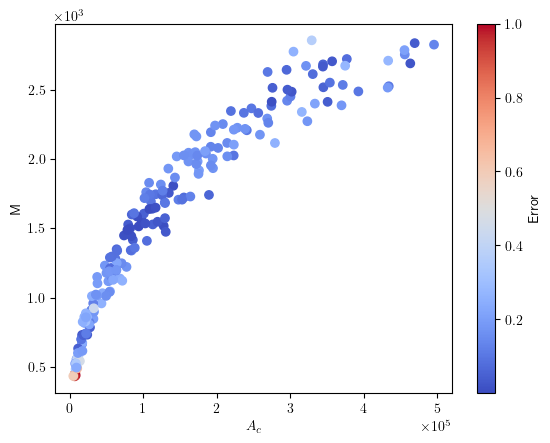

In [272]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col1 = np.abs(y_test_b - y_predict_lr_b)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

In [273]:
#X_test_heatmap_b = pd.DataFrame(X_test_b)
#X_test_heatmap_b = X_test_heatmap_b.assign(A = y_predict_lr_b)
#X_test_heatmap_b = X_test_heatmap_b.drop(columns=[0,1,2,5])
#X_test_heatmap_b.to_csv("predict-bound.csv",index=False, header=False)

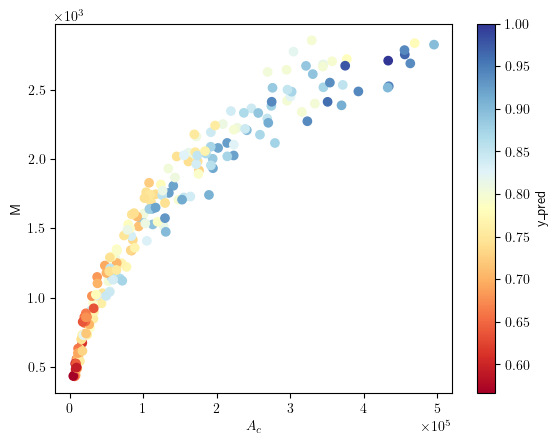

In [274]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col2 = y_test_b
col2 = col2/col2.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col2, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-real.eps',format='eps',dpi=300)
plt.show()

In [275]:
col_bool = col1 == col2
col_bool[col_bool==True]

Series([], Name: 6, dtype: bool)

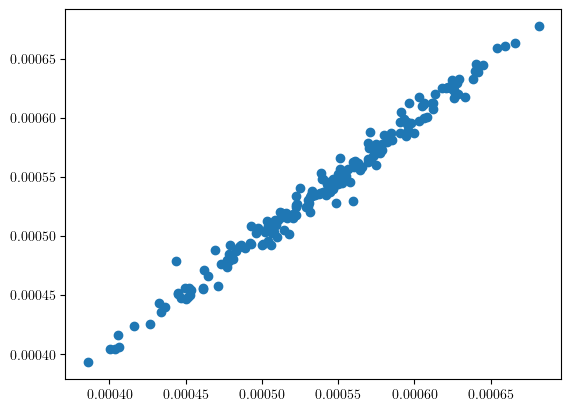

In [276]:
figsct_b1 = plt.figure()
plt.scatter(y_test_b, y_predict_rf_b)


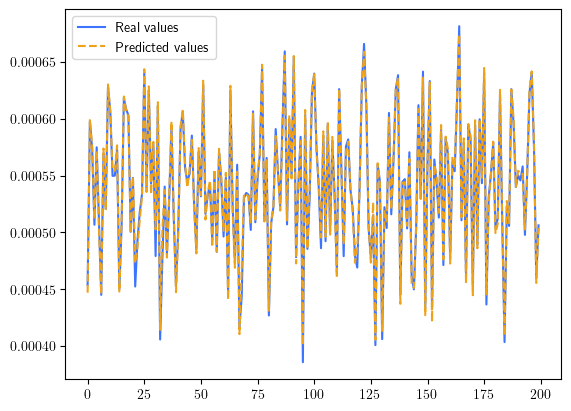

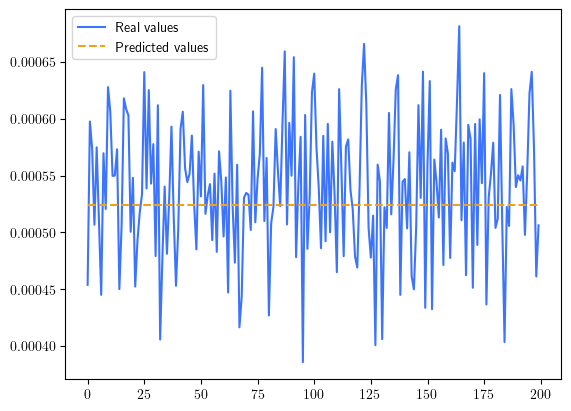

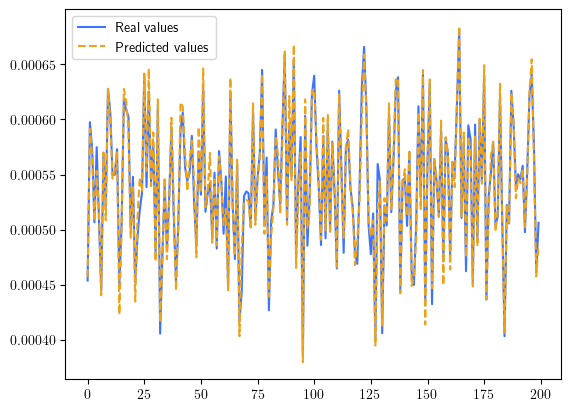

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


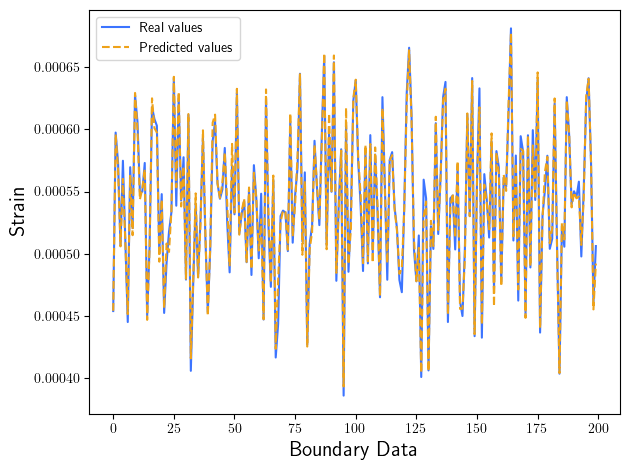

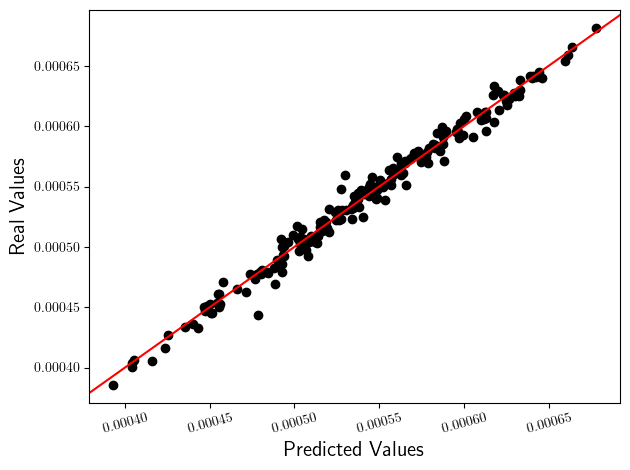

In [277]:
x=np.arange(0,len(y_test_b),1)

fig1_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_b, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/bound-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/bound-regression.svg')
plt.show()

fig_true_predict_b, ax = plt.subplots()
plt.plot(y_predict_rf_b, y_test_b, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('./figures/bound-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

### Bound --> Kernel

In [278]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [279]:
lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_b)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_b)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_b))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_b))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_b))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )





 0.0011378512843957284 
 0.0011578014799446578 
 1.3208186984448841e-06 
 1.3249910019900012e-06 



## Testing the Kernel + Bound

### Kernel + Bound --> Kernel

In [280]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [281]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )
#print(mse_dt, mse_rf)


 0.00041528025290052005 
 0.00045038440231621915 
 1.0032406591091807e-07 
 4.0111013218145264e-08 



### Kernel + Bound --> Bound

In [282]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [283]:
lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.00041313630624048 
 0.0007310511329927781 
 6.710214459350814e-08 
 2.256071499359043e-08 



### Kernel + Bound --> Kernel + Bound

In [284]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [285]:
mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_kb_std, y_train_kb)
y_predict_mlp_kb = mlp.predict(X_test_kb_std)
y_predict_mlp_kernel = y_predict_mlp_kb[y_test_class==0]
y_predict_mlp_bound = y_predict_mlp_kb[y_test_class==1]

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_std)
y_predict_lr_kernel = y_predict_lr_kb[y_test_class==0]
y_predict_lr_bound = y_predict_lr_kb[y_test_class==1]
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_std)
y_predict_svr_kernel = y_predict_svr_kb[y_test_class==0]
y_predict_svr_bound = y_predict_svr_kb[y_test_class==1]
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []

mae_k_dt = []
rmse_k_dt = []
r2_k_dt = []
mape_k_dt = []

mae_b_dt = []
rmse_b_dt = []
r2_b_dt = []
mape_b_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_std)
    y_predict_dt_kernel = y_predict_dt_kb[y_test_class==0]
    y_predict_dt_bound = y_predict_dt_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_dt_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_dt_kb))
    r2 = r2_score(y_test_kb, y_predict_dt_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_dt_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_dt_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    mape_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_dt_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_dt_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_dt_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_dt_bound)

    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)

    mae_k_dt.append(mae_k)
    rmse_k_dt.append(rmse_k)
    r2_k_dt.append(r2_k)
    mape_k_dt.append(mape_k)

    mae_b_dt.append(mae_b)
    rmse_b_dt.append(rmse_b)
    r2_b_dt.append(r2_b)
    mape_b_dt.append(mape_b)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []

mae_k_rf = []
rmse_k_rf = []
r2_k_rf = []
mape_k_rf= []

mae_b_rf = []
rmse_b_rf = []
r2_b_rf = []
mape_b_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_std)
    y_predict_rf_kernel = y_predict_rf_kb[y_test_class==0]
    y_predict_rf_bound = y_predict_rf_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_rf_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_rf_kb))
    r2 = r2_score(y_test_kb, y_predict_rf_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_rf_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    mpae_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_rf_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_rf_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_rf_bound)

    mae_rf.append(mae)
    rmse_rf.append(rmse)  
    r2_rf.append(r2)
    mape_rf.append(mape)

    mae_k_rf.append(mae_k)
    rmse_k_rf.append(rmse_k)  
    r2_k_rf.append(r2_k)
    mape_k_rf.append(mape_k)

    mae_b_rf.append(mae_b)
    rmse_b_rf.append(rmse_b)  
    r2_b_rf.append(r2_b)
    mape_b_rf.append(mape_b)

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_lr_kb))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_mlp_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_svr_kb))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_kb, y_predict_lr_kb)
mae_mlp = metrics.mean_absolute_error(y_test_kb, y_predict_mlp_kb)
mae_svr = metrics.mean_absolute_error(y_test_kb, y_predict_svr_kb)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_kb, y_predict_lr_kb)
r2_mlp = r2_score(y_test_kb, y_predict_mlp_kb)
r2_svr = r2_score(y_test_kb, y_predict_svr_kb)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_mlp = mean_absolute_percentage_error(y_test_kb, y_predict_mlp_kb)
mape_svr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

rmse_k_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_lr_kernel))
rmse_k_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel))
rmse_k_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_svr_kernel))
rmse_k_dt = np.mean(rmse_k_dt)
rmse_k_rf = np.mean(rmse_k_rf)
mae_k_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mae_k_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mae_k_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mae_k_dt = np.mean(mae_k_dt)
mae_k_rf = np.mean(mae_k_rf)
r2_k_lr = r2_score(y_test_kb[y_test_class==0], y_predict_lr_kernel)
r2_k_mlp = r2_score(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
r2_k_svr = r2_score(y_test_kb[y_test_class==0], y_predict_svr_kernel)
r2_k_dt = np.mean(r2_k_dt)
r2_k_rf = np.mean(r2_k_rf)
mape_k_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mape_k_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mape_k_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mape_k_dt = np.mean(mape_k_dt)
mape_k_rf = np.mean(mape_k_rf)

rmse_b_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_lr_bound))
rmse_b_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_mlp_bound))
rmse_b_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_svr_bound))
rmse_b_dt = np.mean(rmse_b_dt)
rmse_b_rf = np.mean(rmse_b_rf)
mae_b_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_lr_bound)
mae_b_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_mlp_bound)
mae_b_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_svr_bound)
mae_b_dt = np.mean(mae_b_dt)
mae_b_rf = np.mean(mae_b_rf)
r2_b_lr = r2_score(y_test_kb[y_test_class==1], y_predict_lr_bound)
r2_b_mlp = r2_score(y_test_kb[y_test_class==1], y_predict_mlp_bound)
r2_b_svr = r2_score(y_test_kb[y_test_class==1], y_predict_svr_bound)
r2_b_dt = np.mean(r2_b_dt)
r2_b_rf = np.mean(r2_b_rf)
mape_b_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_lr_kernel)
mape_b_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_mlp_kernel)
mape_b_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_svr_kernel)
mape_b_dt = np.mean(mape_b_dt)
mape_b_rf = np.mean(mape_b_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

print('Root Mean Squared Error (kernel):''\n', 'LR: ''\t', rmse_k_lr, '\n', 'MLP: ''\t', rmse_k_mlp, '\n', 'SVR: ''\t', rmse_k_svr, '\n', 'DT: ''\t', rmse_k_dt, '\n', 'RF: ''\t', rmse_k_rf, '\n', )
print('Mean Absolute Error (kernel):''\n', 'LR: ''\t', mae_k_lr, '\n', 'MLP: ''\t', mae_k_mlp, '\n', 'SVR: ''\t', mae_k_svr, '\n', 'DT: ''\t', mae_k_dt, '\n', 'RF: ''\t', mae_k_rf, '\n', )
print('R2 Score (kernel):''\n', 'LR: ''\t', r2_k_lr, '\n', 'MLP: ''\t', r2_k_mlp, '\n', 'SVR: ''\t', r2_k_svr, '\n', 'DT: ''\t', r2_k_dt, '\n', 'RF: ''\t', r2_k_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_k_lr, '\n', 'MLP: ''\t', mape_k_mlp, '\n', 'SVR: ''\t', mape_k_svr, '\n', 'DT: ''\t', mape_k_dt, '\n', 'RF: ''\t', mape_k_rf, '\n', )

print('Root Mean Squared Error (bound):''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_b_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error (bound):''\n', 'LR: ''\t', mae_b_lr, '\n', 'MLP: ''\t', mae_b_mlp, '\n', 'SVR: ''\t', mae_b_svr, '\n', 'DT: ''\t', mae_b_dt, '\n', 'RF: ''\t', mae_b_rf, '\n', )
print('R2 Score (bound):''\n', 'LR: ''\t', r2_b_lr, '\n', 'MLP: ''\t', r2_b_mlp, '\n', 'SVR: ''\t', r2_b_svr, '\n', 'DT: ''\t', r2_b_dt, '\n', 'RF: ''\t', r2_b_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_b_lr, '\n', 'MLP: ''\t', mape_b_mlp, '\n', 'SVR: ''\t', mape_b_svr, '\n', 'DT: ''\t', mape_b_dt, '\n', 'RF: ''\t', mape_b_rf, '\n', )


Root Mean Squared Error:
 LR: 	 0.00041420966670464583 
 MLP: 	 0.02843323844529667 
 SVR: 	 0.0006071580802804828 
 DT: 	 0.0002971823575472064 
 RF: 	 0.000176466433303401 

Mean Absolute Error:
 LR: 	 0.0003560745597438806 
 MLP: 	 0.022222487823652035 
 SVR: 	 0.0005627139224670774 
 DT: 	 0.00014238374728323195 
 RF: 	 0.00011307116824254757 

R2 Score:
 LR: 	 0.4956983918401069 
 MLP: 	 -2375.306998586379 
 SVR: 	 -0.08356121407774397 
 DT: 	 0.7401906801710021 
 RF: 	 0.908463109739513 

MAPE Score:
 LR: 	 0.8017931144325385 
 MLP: 	 27.944471700633038 
 SVR: 	 0.8017931144325385 
 DT: 	 0.15012866932867142 
 RF: 	 0.13835607878798892 

Root Mean Squared Error (kernel):
 LR: 	 0.00041528025290052005 
 MLP: 	 0.02843144214991682 
 SVR: 	 0.0004503844023162192 
 DT: 	 0.0003249214854168397 
 RF: 	 0.0010587190773520907 

Mean Absolute Error (kernel):
 LR: 	 0.0003514349435685077 
 MLP: 	 0.021960840501743347 
 SVR: 	 0.0003968409532732139 
 DT: 	 0.00020021322821261656 
 RF: 	 0.0

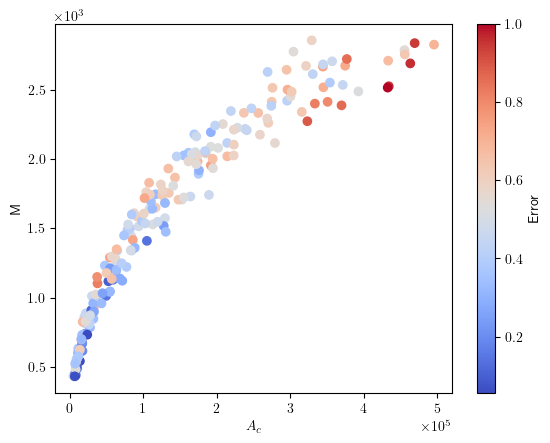

In [286]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==1])
col1 = np.abs(y_test_kb[y_test_class==0] - y_predict_lr_bound)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

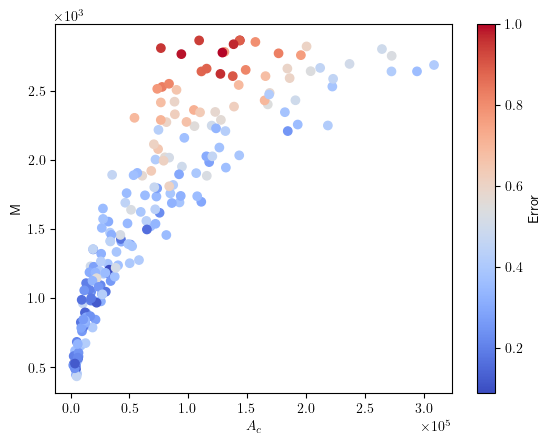

In [287]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==0])
col1 = np.abs(y_test_kb[y_test_class==1] - y_predict_lr_kernel)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


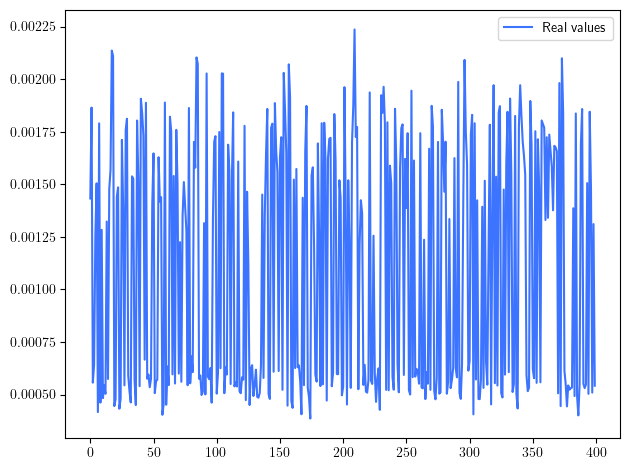

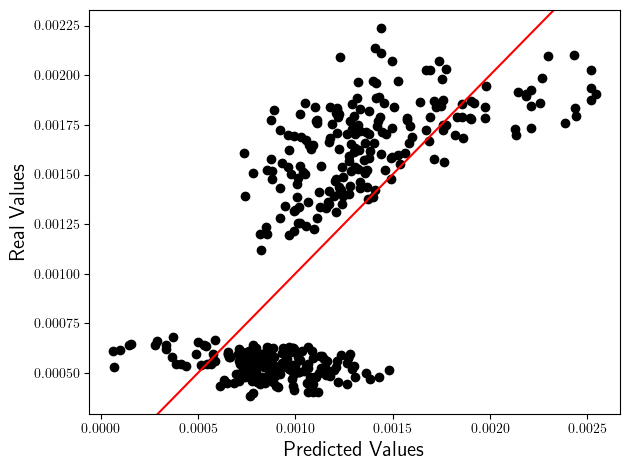

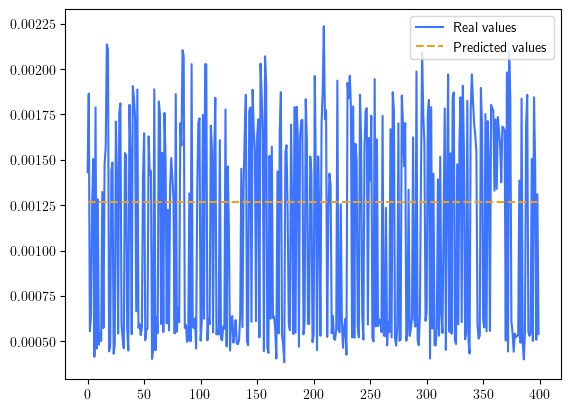

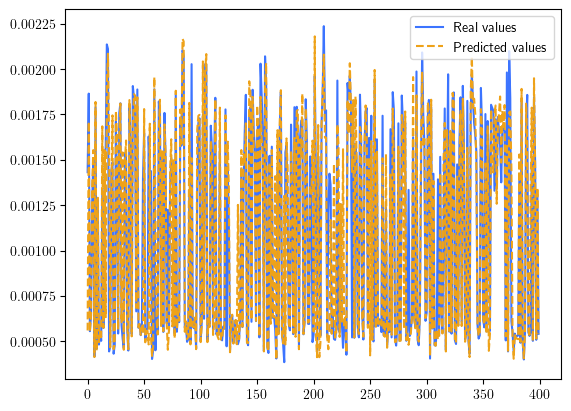

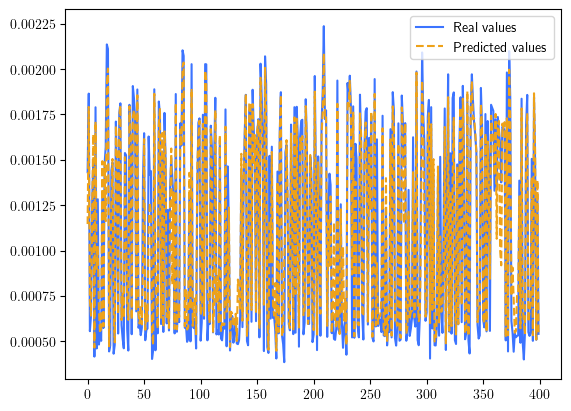

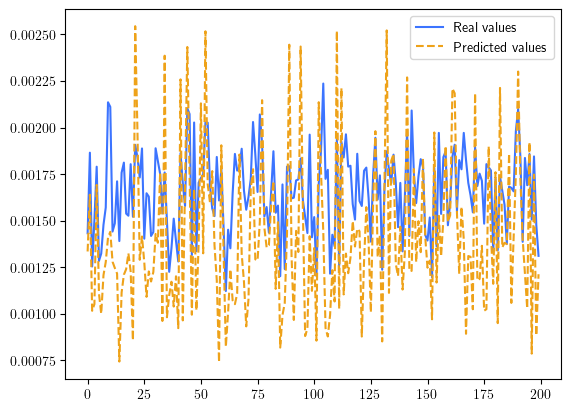

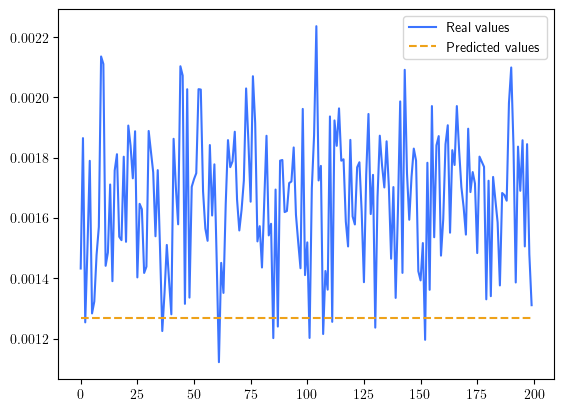

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


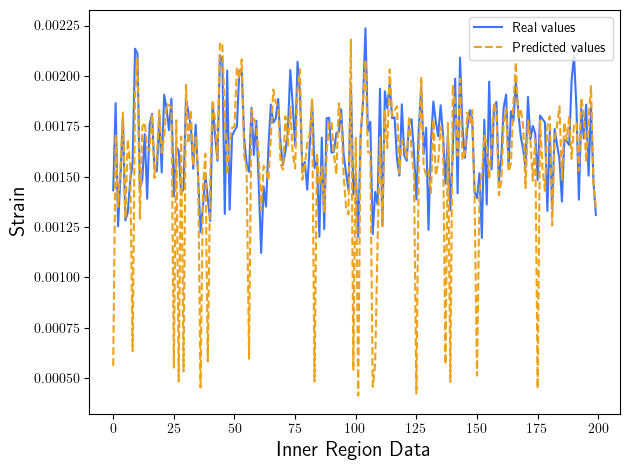

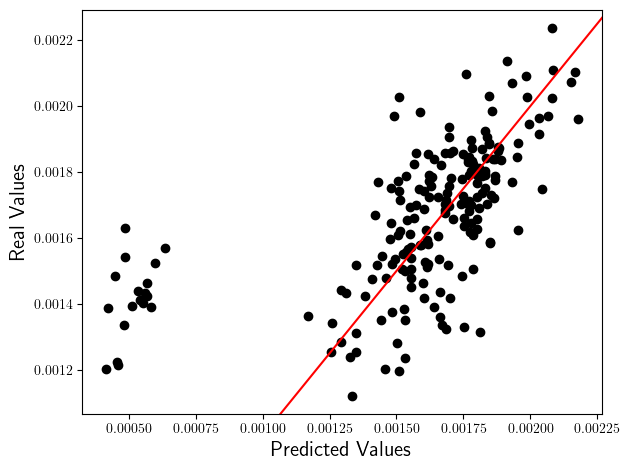

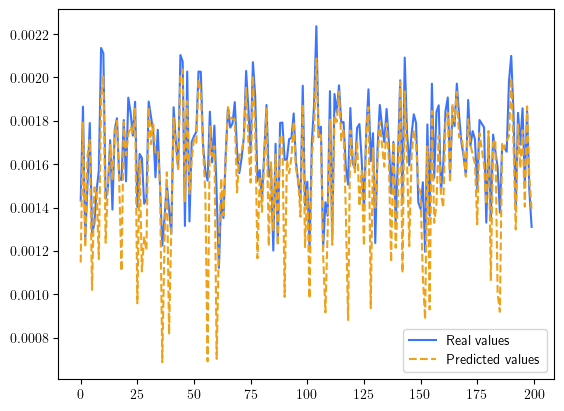

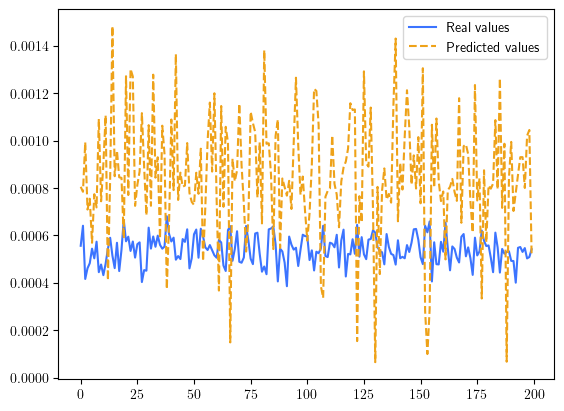

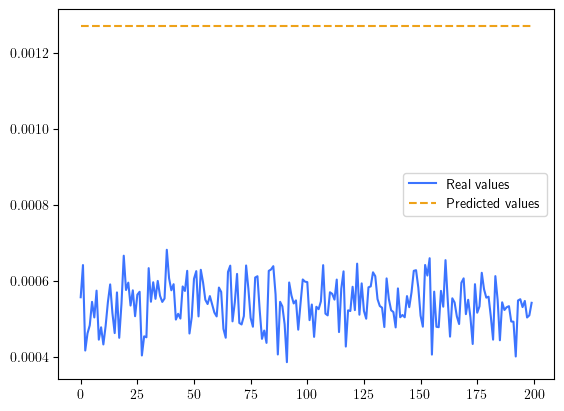

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


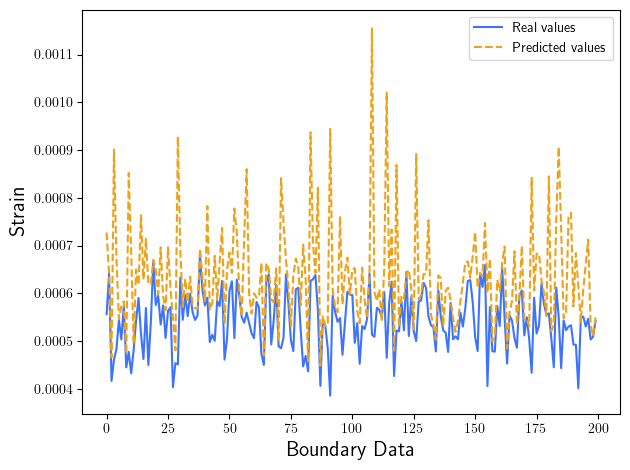

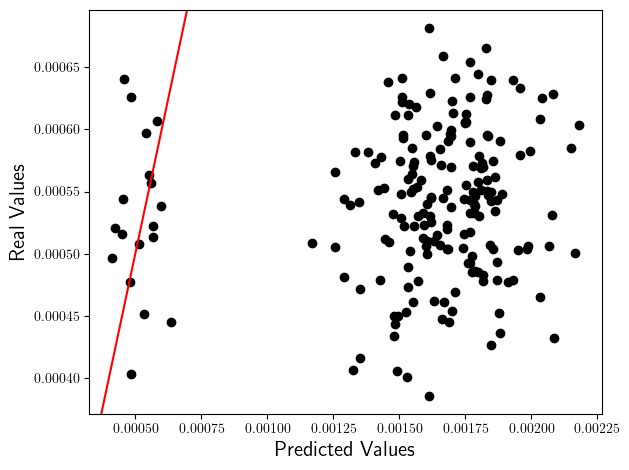

In [288]:
x=np.arange(0,len(y_test_kb),1)

fig1_kb = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_lr_kb, y_test_kb, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x2 = np.arange(0,len(y_test_kb[y_test_class==0]),1)

fig1k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_lr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_svr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_dt_kernel, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Inner Region Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/kernel-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/kernel-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==0], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/kernel-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig4k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_rf_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x3 = np.arange(0,len(y_test_kb[y_test_class==1]),1)

fig1b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_lr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_svr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_rf_bound, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/bound-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/bound-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==1], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/bound-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()